In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as tdist

## Defining cells

In [3]:
class RNNCell(nn.Module):
    """A vanilla RNN cell
    
    An RNN cell which takes two inputs: x and previous hidden state
    and outputs the current hidden state and output.
    
    The RNN cell can be used as components for the following designs:
    * One-to-one: https://stanford.edu/~shervine/images/rnn-one-to-one.png
    * One-to-many: https://stanford.edu/~shervine/images/rnn-one-to-many.png
    * Many-to-one: https://stanford.edu/~shervine/images/rnn-many-to-one.png
    * Many-to-many
        * Same: https://stanford.edu/~shervine/images/rnn-many-to-many-same.png
        * Different: https://stanford.edu/~shervine/images/rnn-many-to-many-different.png
    * Bidirectional RNNs: https://stanford.edu/~shervine/images/bidirectional-rnn.png
    * Deep RNNs: https://stanford.edu/~shervine/images/deep-rnn.png
    
    Parameters
    ==========
    input_dim: Dimension of input data
    output_dim: Dimension of outputs for each input
    hidden_dim: Size of hidden state

    """
    def __init__(self, input_dim, output_dim, hidden_dim, xavier_init=False):
        super().__init__()
        self.weights_hidden = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.weights_input = nn.Parameter(torch.randn(input_dim, hidden_dim))
        self.weights_output = nn.Parameter(torch.randn(hidden_dim, output_dim))
        self.bias_state = nn.Parameter(torch.randn(hidden_dim))
        self.bias_output = nn.Parameter(torch.randn(output_dim))
        self.g1 = nn.Sigmoid()
        self.g2 = nn.Tanh()
    
    def forward(self, x, hidden):
        # Design from: 
        #    https://stanford.edu/~shervine/images/description-block-rnn.png
        #    https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks
        
        # W_{ax}x^t
        input_actv = torch.matmul(x, self.weights_input)
        # W_{aa}a^{t-1}
        old_state_actv = torch.matmul(hidden, self.weights_hidden)
        # updated hidden state (new state)
        # g_1(W_{aa}a^{t-1} + W_{ax}x^t + b_a)
        hidden = self.g1(old_state_actv + input_actv + self.bias_state)
        
        # W_{ya}a^t + b_y
        output_actv = torch.matmul(hidden, self.weights_output)
        # g_2(W_{ya}a^t + b_y)
        output = self.g2(output_actv + self.bias_output)
        
        return output, hidden

In [4]:
rnn = RNNCell(512, 2, 256)
inputs = torch.randn(3,5,512)
hidden = torch.randn(1, 5, 256)
o, h = rnn(inputs, hidden)

In [5]:
print(inputs.shape)
print(o.shape)
print(hidden.shape)

torch.Size([3, 5, 512])
torch.Size([3, 5, 2])
torch.Size([1, 5, 256])


In [6]:
class LayerNorm(nn.Module):

    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

In [7]:
class LSTMCell(nn.Module):
    """A vanilla LSTM cell       
    
    An LSTM cell which takes two inputs: x and previous hidden state
    and outputs the current cell state and hidden state.
    Conditionally, an output cell can also be learnt where the final
    hidden state is reprojected to the required dimension.
    
    Parameters
    ==========
    input_dim: Dimension of input data
    hidden_dim: Size of hidden state
    output_dim: Dimension of outputs for each input

    """
    def __init__(self, input_dim, hidden_dim, output_dim=None, xavier_init=False):
        super().__init__()
        dim_size = input_dim + hidden_dim
        if xavier_init:
            n = (dim_size + hidden_dim) / 2
            self.initialize_with_Xavier(n, dim_size, hidden_dim, output_dim)
        else:
            self.weights_forget = nn.Parameter(torch.randn(dim_size, hidden_dim))
            self.bias_forget = nn.Parameter(torch.randn(hidden_dim))
            self.weights_input = nn.Parameter(torch.randn(dim_size, hidden_dim))
            self.bias_input = nn.Parameter(torch.randn(hidden_dim))
            self.weights_candidate = nn.Parameter(torch.randn(dim_size, hidden_dim))
            self.bias_candidate = nn.Parameter(torch.randn(hidden_dim))
            self.weights_output = nn.Parameter(torch.randn(dim_size, hidden_dim))
            self.bias_output = nn.Parameter(torch.randn(hidden_dim))
            if output_dim is not None:
                self.output_projection = nn.Parameter(torch.randn(hidden_dim, output_dim))
                self.softmax = nn.Softmax(dim=2)
        
        self.g1 = nn.Sigmoid()
        self.g2 = nn.Tanh()
    
    def forward(self, x, hidden_state, old_state):
        # Design and notations from:
        #    https://colah.github.io/posts/2015-08-Understanding-LSTMs/
        
        # h^{t-1}x^t
        concat_inputs = torch.cat((x, hidden_state), dim=2)
        
        # Forget gate: $\Gamma_f = \sigma(W_f.[h_{t-1}, x_t] + b_f)$
        # Determines what(or how much) to throw away from old state
        forget_g = self.g1(torch.matmul(concat_inputs, self.weights_forget) + 
                           self.bias_forget)
        
        # Input gate: $\Gamma_i = \sigma(W_i.[h_{t-1}, x_t] + b_i)$
        # Decides which part of input is to be added
        input_g = self.g1(torch.matmul(concat_inputs, self.weights_input) + 
                          self.bias_input)
        
        # Current candidate: $\widetilde{C_t} = tanh(W_C.[h_{t-1}, x_t] + b_C)$
        # Potential candidate to update the state with
        candidate_new = self.g2(torch.matmul(concat_inputs, self.weights_candidate) + 
                                self.bias_candidate)
        
        # New state: $C_t = f_t * C_{t-1} + i_t * \widetilde{C_t}$
        new_state = torch.mul(forget_g, old_state) + \
                    torch.mul(input_g, candidate_new)
        
        # Output gate: $\Gamma_o = \sigma(W_o.[h_{t-1}, x_t] + b_o)$
        # Determines what to output based on current input and
        #    previous hidden state
        output_g = self.g1(torch.matmul(concat_inputs, self.weights_output) + 
                           self.bias_output)
        # New hidden state/output: $h_t = \Gamma_o * tanh(C_t)$
        hidden_state = torch.mul(output_g, self.g2(new_state))
        
        output = None
        if hasattr(self, 'output_projection') and hasattr(self, 'softmax'):
            output = self.softmax(torch.matmul(hidden_state, self.output_projection))
        
        return new_state, hidden_state, output
    
    def initialize_with_Xavier(self, n_var, dim_size, hidden_dim, output_dim):
        gauss = tdist.Normal(0, 1 / np.sqrt(n_var))
        self.weights_forget = nn.Parameter(gauss.sample((dim_size, hidden_dim)))
        self.bias_forget = nn.Parameter(gauss.sample((hidden_dim,)))
        self.weights_input = nn.Parameter(gauss.sample((dim_size, hidden_dim)))
        self.bias_input = nn.Parameter(gauss.sample((hidden_dim,)))
        self.weights_candidate = nn.Parameter(gauss.sample((dim_size, hidden_dim)))
        self.bias_candidate = nn.Parameter(gauss.sample((hidden_dim,)))
        self.weights_output = nn.Parameter(gauss.sample((dim_size, hidden_dim)))
        self.bias_output = nn.Parameter(gauss.sample((hidden_dim,)))
        if output_dim is not None:
            self.output_projection = nn.Parameter(gauss.sample((hidden_dim, output_dim)))
            self.softmax = nn.Softmax(dim=2)
        

In [8]:
# LSTM without Output cell and Xavier initialization

lstm = LSTMCell(512, 256)
batch = 2
inputs = torch.randn(3, batch, 512)
hidden = torch.randn(1, batch, 256)
state = torch.randn(256)
new_state, h, _ = lstm(inputs[0].unsqueeze(0), hidden, state)

In [9]:
print(inputs[0].unsqueeze(0).shape)
print(new_state.shape)
print(h.shape)

torch.Size([1, 2, 512])
torch.Size([1, 2, 256])
torch.Size([1, 2, 256])


In [10]:
# LSTM with Output cell and Xavier initialization

lstm = LSTMCell(512, 256, 2, True)
batch = 5
inputs = torch.randn(3, batch, 512)
hidden = torch.randn(1, batch, 256)
state = torch.randn(256)

In [11]:
new_state, h, o = lstm(inputs[0].unsqueeze(0), hidden, state)
print(o.shape)
print(h.shape)
print(new_state.shape)

torch.Size([1, 5, 2])
torch.Size([1, 5, 256])
torch.Size([1, 5, 256])


In [12]:
print(torch.argmax(o, dim=2))
gt = (torch.ones(batch).long() - torch.argmax(o, dim=2)[0].long())
print(gt)

tensor([[0, 1, 0, 0, 0]])
tensor([1, 0, 1, 1, 1])


In [13]:
loss_criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)
optimizer.zero_grad()

loss = loss_criterion(o.view(batch, -1), gt)
print("Loss: {}".format(loss.item()))
loss.backward()

optimizer.step()

Loss: 0.7407665252685547


### Full LSTM Architecture

In [103]:
class LSTM(nn.Module):
    def __init__(self, ncell, input_dim, hidden_dim, output_dim, 
                 bidirectional=False, xavier_init=True):
        super().__init__()
        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim
        # Creating architecture for Left-to-Right Sequence
        archi = []
        for i in range(ncell):
            archi.append(LSTMCell(input_dim, hidden_dim, 
                                  None, xavier_init))
        self.archi = nn.ModuleList(archi)
        self.final_layer = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=2) # use nn.LogSoftmax?
        
        if bidirectional:
            # Creating architecture for Right-to-Left Sequence
            archi_rev = []
            for i in range(ncell):
                archi_rev.append(LSTMCell(input_dim, hidden_dim, 
                                          None, xavier_init))
            self.archi_rev = nn.ModuleList(archi_rev)
            self.final_layer = nn.Linear(2 * hidden_dim, output_dim)               
        
    def forward(self, x, hidden_state, cell_state):
        history = len(self.archi)
        seq_length = x.shape[0]
        hidden_state_rev = hidden_state.clone()
        cell_state_rev = cell_state.clone()
        assert(seq_length >= history)
        # Forward pass for Left-to-Right sequence
        for i in range(seq_length - history + 1):
            for j in range(history):
                inputs = x[i+j].unsqueeze(0)
                cell_state, hidden_state, _ = self.archi[j](inputs, 
                                                            hidden_state, 
                                                            cell_state)
        if self.bidirectional:
            # Forward pass for Right-to-Left sequence
            for i in range(seq_length - history + 1):
                for j in range(history):
                    inputs = x[i+j].unsqueeze(0)
                    cell_state_rev, 
                    hidden_state_rev,
                    _ = self.archi_rev[history-j-1](inputs, hidden_state_rev, cell_state_rev)
            hidden_state = torch.cat((hidden_state, hidden_state_rev), dim=-1)
        
        output = self.softmax(self.final_layer(hidden_state))
        return cell_state, hidden_state, output
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [104]:
# history = 4
# seq_length = 10
# for i in range(seq_length - history + 1):
#     for j in range(history):
#         print(i+j, end=" ")
#     print()
# print()
# archi = ["archi_1", "archi_2", "archi_3", "archi_4"]
# for i in range(0, seq_length - history + 1)[::-1]:
#     for j in range(history)[::-1]:
#         print(i+j, end=" ")
#         #print("{} {}".format(history-j-1, i+j), end="\t")
#     print()

### Training modules

In [105]:
def train(model, data_loader, batch_size, optimizer, epochs):
    """
    Trains the model of class LSTM using data from data_loader passed as argument
    
    Parameters
    ==========
    model: object of class LSTM
    data_loader: an object containing data and functions to sample batches
        The sample() function of the object returns two tensors
        x - which is a 3D tensor of [sequence, batch, dim]
            Example-A batch of 10 sentences of 5 words each where each word has
            an embedding vector of size 256, the 3D tensor shape will be [5, 10, 256]
        y - a 1D tensor containing the classes as integers (torch.long())
    
    Returns
    =======
    Trained model object of class LSTM
    
    """
    loss_list = []
    for i in range(epochs):
        loss_tracker = []
        for i, x, y in enumerate(data_loader.sample_batch(batch_size)):
            hidden_state = torch.zeros(1, batch_size, model.hidden_dim)
            cell_state = torch.zeros(1, batch_size, model.hidden_dim)
            cell_state, hidden_state, output = lstm(x=x_train, 
                                                    hidden_state=hidden_state, 
                                                    cell_state=cell_state)
            loss = loss_criterion(output.view(batch_size, -1), y_train.long())
            print("Epoch #{}: Batch {}/{} -- Loss = {}".format(i+1, j+1, int(x_size/batch_size), 
                                                               loss.item()), end='\r')
            loss_tracker.append(loss.item())
            # backward pass for the batch (+ weight updates)
            loss = loss_criterion(output.view(batch_size, -1), y_train.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_list.append(np.mean(loss_tracker))
        loss_tracker = []
        print("\nEpoch #{}: Average loss is {}".format(i+1, loss_list[-1]))
        print()
    return model

In [106]:
from sklearn.metrics import confusion_matrix, f1_score

def evaluate(model, test_data, verbose=True):
    """
    Evaluates the model of class LSTM using test data passed
    
    Parameters
    ==========
    model: object of class LSTM
    test_data: a tuple containing (x, y) 
        x - a 3D tensor of [sequence, len_test_data, dim]
            Example-A batch of 10 sentences of 5 words each where each word has
            an embedding vector of size 256, the 3D tensor shape will be [5, 10, 256]
        y - a 1D tensor containing the classes as integers (torch.long())
    verbose: prints the confusion matrix and F-score
    
    Returns
    =======
    F-score (float)
    
    """
    x, y = test_data
    batch_size = test_data.shape[1]
    hidden_state = torch.zeros(1, batch_size, model.hidden_dim)
    cell_state = torch.zeros(1, batch_size, model.hidden_dim)
    model.eval()
    with torch.no_grad():
        _, _, output = lstm(x=x_train, hidden_state=hidden_state, cell_state=cell_state)   
    if verbose:
        print(confusion_matrix(y, torch.argmax(output, 2)[0].numpy()))
        print(f1_score(y, torch.argmax(output, 2)[0].numpy()))
    return f1_score(y, torch.argmax(output, 2)[0].numpy())

## Creating datasets

### Counting sequence

In [28]:
x = torch.randint(0, 2, (1000,100)).float()
y = torch.sum(x, 1)

In [49]:
input_dim = 1
seq_length = 100
hidden_dim = 50
output_dim = 100
lstm = LSTMCell(input_dim=input_dim, hidden_dim=hidden_dim, 
                output_dim=output_dim, xavier_init=True)
optimizer = optim.Adam(lstm.parameters(), lr=0.001)
loss_criterion = nn.CrossEntropyLoss()

In [33]:
# Training Loop
batch_size = 10
# for i in range(10):
for j in range(int(1000/batch_size)):
    start = j * batch_size
    end = min((j+1) * batch_size, 1000)
    x_train = torch.tensor([]).float()
    y_train = y[start:end]
    # creating the 3D tensor for the batch: seq x batch x dim
    for data in x[start:end]:
        x_train = torch.cat((x_train, data.view(seq_length, 1, 1)), dim=1)
    # initializing states
    hidden_state = torch.zeros(1, batch_size, hidden_dim)
    cell_state = torch.zeros(1, batch_size, hidden_dim)
    # forward pass for the batch
    for i, seq_i in enumerate(x_train):        
        cell_state, hidden_state, output = lstm(x=seq_i.unsqueeze(0), 
                                                hidden_state=hidden_state, 
                                                old_state=cell_state)
    loss = loss_criterion(output.view(batch_size, -1), y_train.long())
    print("Epoch #{}: Batch {}/{} -- Loss = {}".format(i+1, j+1, int(1000/batch_size), 
                                                       loss.item()), end='\r')
    # backward pass for the batch (+ weight updates)
    loss = loss_criterion(output.view(batch_size, -1), y_train.long())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [34]:
print(torch.argmax(output, dim=2))

tensor([[51, 51, 51, 51, 51, 51, 51, 51, 51, 51]])


### Classifying product as positive/negative

In [107]:
input_dim = 1
seq_length = 10
hidden_dim = 50
output_dim = 2
x_size = 1000

x = torch.randn((x_size, seq_length)).float()
y = torch.prod(x, 1)
y[y >= 0] = 1
y[y < 0] = 0
# print(torch.histc(y, bins=2))

lstm = LSTM(ncell=4, input_dim=input_dim, hidden_dim=hidden_dim, 
            output_dim=output_dim, bidirectional=False, xavier_init=True)
optimizer = optim.Adam(lstm.parameters(), lr=0.001)
loss_criterion = nn.CrossEntropyLoss()
print(lstm.count_parameters())

41702


In [96]:
# Testing of batch creating and forward pass

# x_train = x
# y_train = y

# batch_size = 4
# j = 0
# start = j * batch_size
# end = min((j+1) * batch_size, 1000)

# x_train = torch.tensor([]).float()
# y_train = y[start:end]
# # creating the 3D tensor for the batch: seq x batch x dim
# for data in x[start:end]:
#     x_train = torch.cat((x_train, data.view(seq_length, 1, 1)), dim=1)

# # initializing states
# hidden_state = torch.zeros(1, batch_size, hidden_dim)
# cell_state = torch.zeros(1, batch_size, hidden_dim)

# print(x_train.shape, y_train.shape)
# print(hidden_state.shape, cell_state.shape)

# s,h,o = lstm(x_train, hidden_state, cell_state)

In [ ]:
# TRAINING LOOP

# Each batch passed to LSTM() is expected to be a 3D Tensor where
# the dimensions describe [sequence_size, batch_size, dim_size]

batch_size = 4

for i in range(10):
    loss_tracker = []
    for j in range(int(x_size/batch_size)):
        start = j * batch_size
        end = min((j+1) * batch_size, x_size)
        x_train = torch.tensor([]).float()
        y_train = y[start:end]
        # creating the 3D tensor for the batch: seq x batch x dim
        for data in x[start:end]:
            x_train = torch.cat((x_train, data.view(seq_length, 1, 1)), dim=1)
        # initializing states
        hidden_state = torch.zeros(1, batch_size, hidden_dim)
        cell_state = torch.zeros(1, batch_size, hidden_dim)
        cell_state, hidden_state, output = lstm(x=x_train, 
                                                hidden_state=hidden_state, 
                                                cell_state=cell_state)
        loss = loss_criterion(output.view(batch_size, -1), y_train.long())
        print("Epoch #{}: Batch {}/{} -- Loss = {}".format(i+1, j+1, int(x_size/batch_size), 
                                                           loss.item()), end='\r')
        loss_tracker.append(loss.item())
        # backward pass for the batch (+ weight updates)
        loss = loss_criterion(output.view(batch_size, -1), y_train.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("\nEpoch #{}: Average loss is {}".format(i+1, np.mean(loss_tracker)))
    loss_tracker = []
    print()

Epoch #1: Batch 250/250 -- Loss = 0.6912937760353088
Epoch #1: Average loss is 0.6943509202003479



In [98]:
# Validating on entire generated data

x_train = torch.tensor([]).float()
y_train = y
# creating the 3D tensor for the batch: seq x batch x dim
for data in x:
    x_train = torch.cat((x_train, data.view(seq_length, 1, 1)), dim=1)
print(x_train.shape)
print(y.shape)
hidden_state = torch.zeros(1, x_train.shape[1], hidden_dim)
cell_state = torch.zeros(1, x_train.shape[1], hidden_dim)
_, _, output = lstm(x=x_train, hidden_state=hidden_state, cell_state=cell_state)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y, torch.argmax(output, 2)[0].numpy()))
print(f1_score(y, torch.argmax(output, 2)[0].numpy()))

torch.Size([10, 1000, 1])
torch.Size([1000])
[[434  55]
 [ 72 439]]
0.8736318407960199


In [100]:
# Validating on newly generated test data

x_test = torch.randn((x_size, seq_length)).float()
y_test = torch.prod(x_test, 1)
y_test[y_test >= 0] = 1
y_test[y_test < 0] = 0

x_train = torch.tensor([]).float()
y_train = y_test
# creating the 3D tensor for the batch: seq x batch x dim
for data in x_test:
    x_train = torch.cat((x_train, data.view(seq_length, 1, 1)), dim=1)
print(x_train.shape)
print(y.shape)
hidden_state = torch.zeros(1, x_train.shape[1], hidden_dim)
cell_state = torch.zeros(1, x_train.shape[1], hidden_dim)
_, _, output = lstm(x=x_train, hidden_state=hidden_state, cell_state=cell_state)
from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(y, torch.argmax(output, 2)[0].numpy()))
print(f1_score(y, torch.argmax(output, 2)[0].numpy()))

torch.Size([10, 1000, 1])
torch.Size([1000])
[[258 231]
 [254 257]]
0.5145145145145146


#### IMDB

In [35]:
# @InProceedings{maas-EtAl:2011:ACL-HLT2011,
#   author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
#   title     = {Learning Word Vectors for Sentiment Analysis},
#   booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},
#   month     = {June},
#   year      = {2011},
#   address   = {Portland, Oregon, USA},
#   publisher = {Association for Computational Linguistics},
#   pages     = {142--150},
#   url       = {http://www.aclweb.org/anthology/P11-1015}
# }

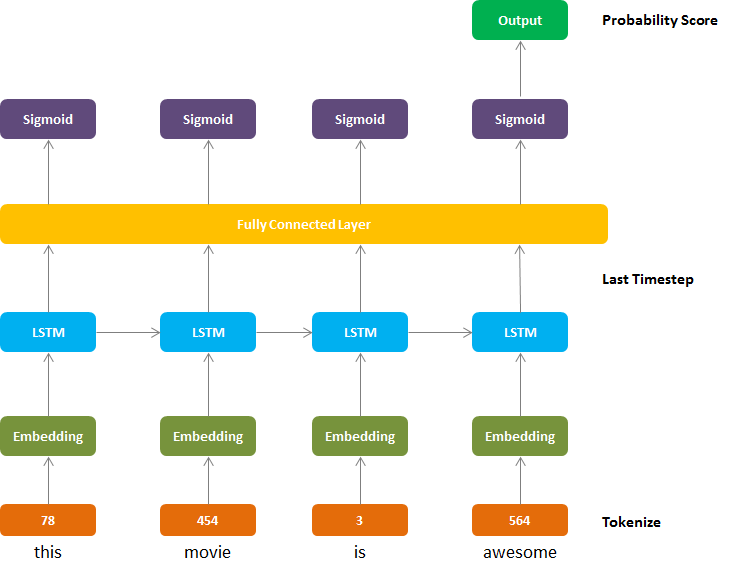

In [113]:
from IPython.display import Image
Image(filename='../img/sentiment.png') 
# source:(https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948)